# Notebook for braided test results

In [1]:
import os, sys, json
import argparse
import platform
import shutil

import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.nn.init import xavier_uniform_, zeros_
from PyQt5.QtWidgets import QApplication

from models import Braided_Classifier
from datasets import Train_Meta_Dataset, Val_Meta_Dataset, Test_Meta_Dataset, Random_Affine, ToTensor, Normalise, collate_fn
from meta_function import meta_loading

## Condensed Prediction

In [2]:
fileDir = "C:/fully_split_data/"
t1MapDir = "C:/T1_Maps/"
modelName = "Not_Norm_Condense_20000"
condense = True
bSize = 6
normQ = False

modelDir = "./models/Braided_Net/{}/".format(modelName)
assert os.path.isdir(modelDir), "Model Directory is not found, please check your model name!"


figDir = "{}Test_Figures/".format(modelDir)
try:
    os.makedirs(figDir)
except FileExistsError as e:
    print(e, "This means you will be overwriting previous results!")

toT = ToTensor()

if normQ:
    norm = Normalise()
    trnsInTest = transforms.Compose([toT,norm])
else:
    trnsInTest = transforms.Compose([toT])

[WinError 183] Cannot create a file when that file already exists: './models/Braided_Net/Not_Norm_Condense_20000/Test_Figures/' This means you will be overwriting previous results!


In [3]:
datasetTest = Test_Meta_Dataset(modelDir=modelDir,fileDir=fileDir,t1MapDir=t1MapDir,size=1000,transform=trnsInTest,load=True,condense=condense)


 Loading Meta Data.... 

 [31199/31199]


In [4]:
loaderTest = DataLoader(datasetTest,batch_size=bSize,shuffle=False,collate_fn=collate_fn,pin_memory=False)

batch = next(iter(loaderTest))
inpMetaSize = batch['Meta'].size()[1]
if condense:
    outSize = 1
else:
    outSize = batch["Tag"].size()[1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

netB = Braided_Classifier(7,inpMetaSize,outSize,xDim=288,yDim=384,device=device)
modelDict = torch.load("{}model.pt".format(modelDir),map_location=device)
netB.load_state_dict(modelDict["state_dict"])
netB = netB.to(device)

testLen = datasetTest.__len__()

testLossCnt = 0

In [5]:
pred = np.zeros((testLen,outSize))
y_test = np.zeros((testLen,outSize))
with torch.no_grad():
    netB.train()
    for i,data in enumerate(loaderTest):
        inpData = data["Images"].to(device)
        eid = data["eid"]
        inpMeta = data["Meta"].to(device)
        y_test[i*bSize:(i+1)*bSize,:] = data["Tag"].numpy()

        # if bSize == 1:
        #     inpMeta.unsqueeze_(0)

        try:
            out = netB(inpData,inpMeta)

            out = torch.sigmoid(out)
            if any(torch.isnan(out)):
                val = torch.isnan(out)
                for idx in range(val.shape[0]):
                    if val[idx,0]:
                        out[idx,0] = 0.0
            pred[i*bSize:(i+1)*bSize,:] = out.cpu().numpy()
        except RuntimeError as e:
            print(e,inpMeta.size(),inpData.size())

        sys.stdout.write("\r\tSubj {}/{}".format(i*bSize,testLen))

	Subj 4998/5000

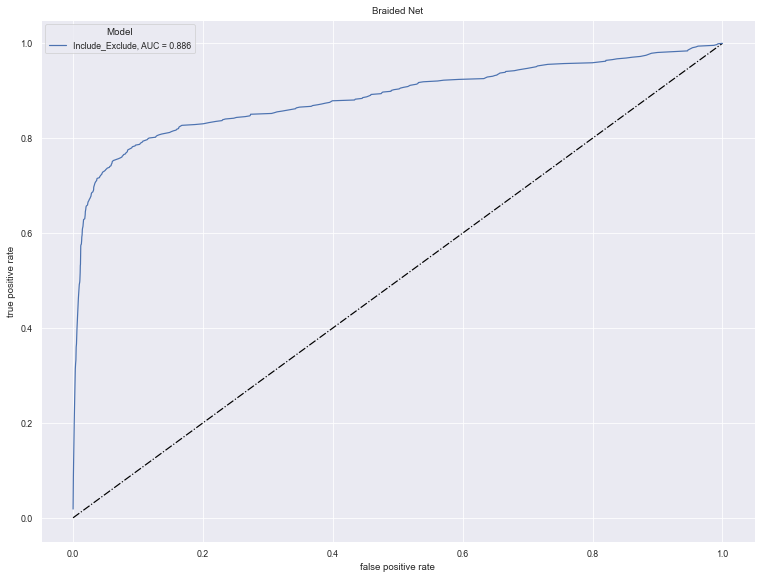

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas
import seaborn as sns

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
plt.rcParams["savefig.format"] = "svg"

sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

# tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
tagNames = ["Include_Exclude"]

for i,name in enumerate(tagNames):
    try:
        fpr,tpr,_ = roc_curve(y_test[:,i],pred[:,i])
        auc_score = roc_auc_score(y_test[:,i],pred[:,i])

        event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

        modelsArr.extend(event)
        fprArr.extend(fpr)
        tprArr.extend(tpr)
    except ValueError as e:
        print(name,e)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Braided Net")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.savefig("{}ROC".format(figDir))
plt.show()


## Not condensed

In [9]:
fileDir = "C:/fully_split_data/"
t1MapDir = "C:/T1_Maps/"
modelName = "Not_Norm_20000"
condense = False
bSize = 4
normQ = False

modelDir = "./models/Braided_Net/{}/".format(modelName)
assert os.path.isdir(modelDir), "Model Directory is not found, please check your model name!"


figDir = "{}Test_Figures/".format(modelDir)
try:
    os.makedirs(figDir)
except FileExistsError as e:
    print(e, "This means you will be overwriting previous results!")

toT = ToTensor()

if normQ:
    norm = Normalise()
    trnsInTest = transforms.Compose([toT,norm])
else:
    trnsInTest = transforms.Compose([toT])

[WinError 183] Cannot create a file when that file already exists: './models/Braided_Net/Not_Norm_20000/Test_Figures/' This means you will be overwriting previous results!


In [11]:
datasetTest = Test_Meta_Dataset(modelDir=modelDir,fileDir=fileDir,t1MapDir=t1MapDir,size=1000,transform=trnsInTest,load=True,condense=condense)


 Loading Meta Data.... 

 [31199/31199]


In [12]:
loaderTest = DataLoader(datasetTest,batch_size=bSize,shuffle=False,collate_fn=collate_fn,pin_memory=False)

batch = next(iter(loaderTest))
inpMetaSize = batch['Meta'].size()[1]
if condense:
    outSize = 1
else:
    outSize = batch["Tag"].size()[1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

netB = Braided_Classifier(7,inpMetaSize,outSize,xDim=288,yDim=384,device=device)
modelDict = torch.load("{}model.pt".format(modelDir),map_location=device)
netB.load_state_dict(modelDict["state_dict"])
netB = netB.to(device)

testLen = datasetTest.__len__()

testLossCnt = 0

In [28]:
pred = np.zeros((testLen,outSize))
y_test = np.zeros((testLen,outSize))
with torch.no_grad():
    netB.train()
    for i,data in enumerate(loaderTest):
        inpData = data["Images"].to(device)
        eid = data["eid"]
        inpMeta = data["Meta"].to(device)
        y_test[i*bSize:(i+1)*bSize,:] = data["Tag"].numpy()

        try:
            out = netB(inpData,inpMeta)

            out = torch.sigmoid(out)
            corrupt = False
            for itm in out:
                if any(torch.isnan(itm)):
                    corrupt = True

            if corrupt:
                # print("Corrupted \n",out)
                val = torch.isnan(out)
                for idx in range(val.shape[0]):
                    for jdx in range(val.shape[1]):
                        if val[idx,jdx]:
                            out[idx,jdx] = 0.0
                # print(out)
            pred[i*bSize:(i+1)*bSize,:] = out.cpu().numpy()
        except RuntimeError as e:
            print(e,inpMeta.size(),inpData.size())

        sys.stdout.write("\r\tSubj {}/{}".format(i*bSize,testLen))

	Subj 4996/5000

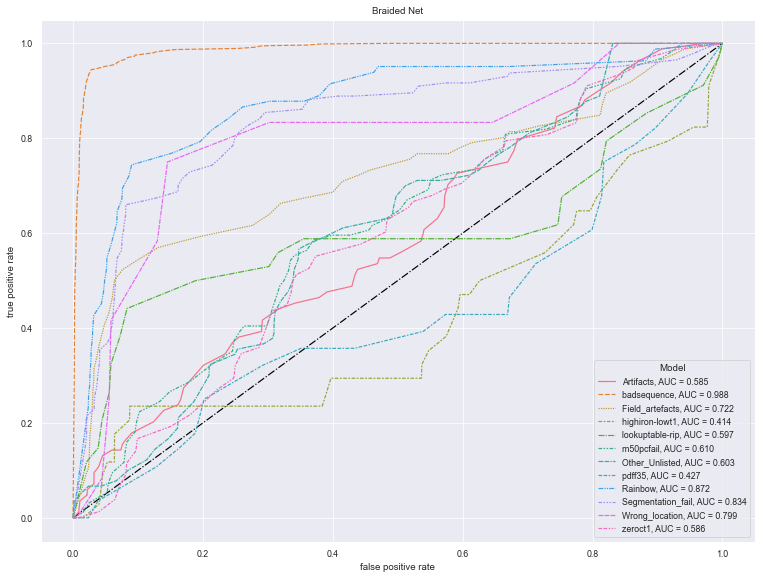

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
import pandas
import seaborn as sns

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
# tagNames = ["Include_Exclude"]

for i,name in enumerate(tagNames):
    try:
        fpr,tpr,_ = roc_curve(y_test[:,i],pred[:,i])
        auc_score = roc_auc_score(y_test[:,i],pred[:,i])

        event = ["{}, AUC = {:.3f}".format(name,auc_score)]*(fpr.shape[0])

        modelsArr.extend(event)
        fprArr.extend(fpr)
        tprArr.extend(tpr)
    except ValueError as e:
        print(name,e)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Braided Net")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()

ipykernel_launcher:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


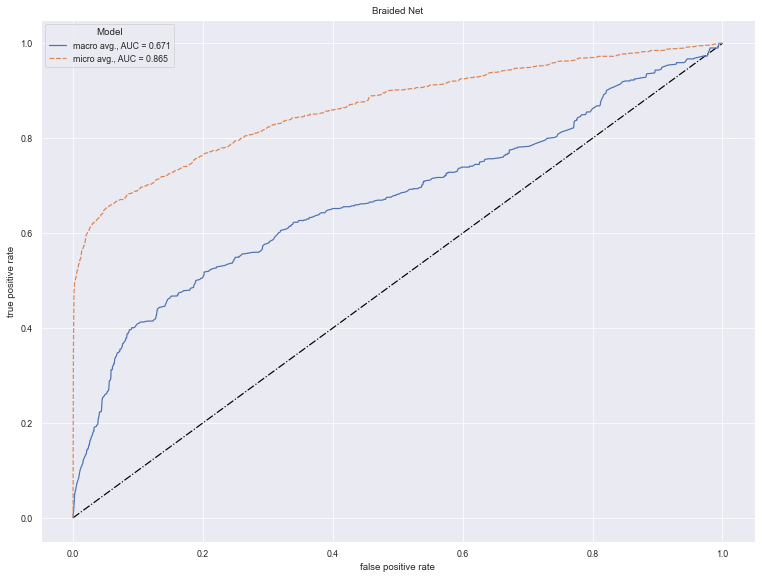

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import interp
import pandas
import seaborn as sns

plt.rcParams['figure.figsize'] = [6.4*2, 4.8*2]
sns.set_theme("paper")
sns.set_style(style="darkgrid")

modelsArr = []
fprArr = []
tprArr = []

tagNames = ['Artifacts', 'badsequence', 'Field_artefacts', 'highiron-lowt1', 'lookuptable-rip', 'm50pcfail', 'Other_Unlisted', 'pdff35', 'Rainbow', 'Segmentation_fail', 'Wrong_location', 'zeroct1']
# tagNames = ["Include_Exclude"]

fprDict = {}
tprDict = {}
rocDict = {}
for i,name in enumerate(tagNames):
    fprDict[name], tprDict[name], _ = roc_curve(y_test[:,i],pred[:,i])
    rocDict[name] = roc_auc_score(y_test[:,i],pred[:,i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fprDict[name] for name in tagNames]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for name in tagNames:
    mean_tpr += interp(all_fpr, fprDict[name], tprDict[name])

# Finally average it and compute AUC
mean_tpr /= len(tagNames)
auc_score = auc(all_fpr,mean_tpr)
event = ["{}, AUC = {:.3f}".format("macro avg.",auc_score)]*(all_fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(all_fpr)
tprArr.extend(mean_tpr)

fpr,tpr,_ = roc_curve(y_test.ravel(),pred.ravel())
auc_score = roc_auc_score(y_test.ravel(),pred.ravel())

event = ["{}, AUC = {:.3f}".format("micro avg.",auc_score)]*(fpr.shape[0])

modelsArr.extend(event)
fprArr.extend(fpr)
tprArr.extend(tpr)

event = np.array(modelsArr)
fpr = np.array(fprArr)
tpr = np.array(tprArr)
df = pandas.DataFrame({"Model":event,"false positive rate":fpr,"true positive rate":tpr})

plt.figure()
plt.title("Braided Net")
sns.lineplot(x=[0,1],y=[0,1],linestyle="-.",color='black')
sns.lineplot(data=df,x="false positive rate",y="true positive rate",hue="Model",style="Model",ci=None)
plt.show()